# Twin Premixed Counter-Flow Flame
This example documents how to simulate two identical, axisymmetric, premixed jets of reactants shooting into each other. 

An illustration of this configuration is shown in the figure below.

![Twin Premixed Flame](images/twinPremixedFlame.png)

### Import modules

In [1]:
import cantera as ct
import numpy as np

print(f"Running Cantera Version: {ct.__version__}")

Running Cantera Version: 2.6.0a4


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.autolayout"] = True

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (8, 6)

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [3]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
gas = ct.Solution("gri30.yaml")

# Create a CH4/Air premixed mixture with equivalence ratio=0.75
gas.set_equivalence_ratio(0.75, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Set the velocity of the reactants
# This is what determines the strain-rate
axial_velocity = 2.0  # in m/s

# Done with initial conditions
# Compute the mass flux, as this is what the Flame object requires
mass_flux = gas.density * axial_velocity  # units kg/m2/s

### Define functions

In [4]:
def derivative(x, y):
    """Differentiation function for data that has variable grid spacing.
    Used here to compute normal strain-rate.
    """
    dydx = np.zeros_like(y)

    dx = np.diff(x)
    dy = np.diff(y)
    dydx[0:-1] = dy / dx

    dydx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dydx


def compute_strain_rates(opposed_flame):
    # Compute the derivative of axial velocity to obtain normal strain rate
    strain_rates = derivative(opposed_flame.grid, opposed_flame.velocity)

    # Obtain the location of the max. strain rate upstream of the pre-heat zone.
    # This is the characteristic strain rate
    max_strain_location = abs(strain_rates).argmax()
    min_velocity_point = opposed_flame.velocity[:max_strain_location].argmin()

    # Characteristic Strain Rate = K
    strain_rate_point = abs(strain_rates[:min_velocity_point]).argmax()
    K = abs(strain_rates[strain_rate_point])

    return strain_rates, strain_rate_point, K


def compute_consumption_speed(opposed_flame):

    Tb = max(opposed_flame.T)
    Tu = min(opposed_flame.T)
    rho_u = max(opposed_flame.density)

    integrand = opposed_flame.heat_release_rate / opposed_flame.cp

    I = np.trapz(integrand, opposed_flame.grid)
    Sc = I / (Tb - Tu) / rho_u

    return Sc


# This function is called to run the solver
def solve_opposed_flame(
    opposed_flame, mass_flux=0.12, loglevel=0, ratio=2, slope=0.3, curve=0.3, prune=0.05
):
    """
    Execute this function to run the Oppposed Flow Simulation This function
    takes a CounterFlowTwinPremixedFlame object as the first argument
    """

    opposed_flame.reactants.mdot = mass_flux
    opposed_flame.set_refine_criteria(
        ratio=ratio, slope=slope, curve=curve, prune=prune
    )

    opposed_flame.show_solution()
    opposed_flame.solve(loglevel, auto=True)

    # Compute the strain rate, just before the flame. This is not necessarily
    # the maximum We use the max. strain rate just upstream of the pre-heat zone
    # as this is the strain rate that computations comprare against, like when
    # plotting Su vs. K
    _, strain_rate_point, K = compute_strain_rates(opposed_flame)

    return np.max(opposed_flame.T), K, strain_rate_point

### Define a flame object, domain width and tranport model

In [5]:
# Define a domain half-width of 2.5 cm, meaning the whole domain is 5 cm wide
width = 0.025

# Create the flame object
opposed_flame = ct.CounterflowTwinPremixedFlame(gas, width=width)

# Uncomment the following line to use a Multi-component formulation. Default is
# mixture-averaged
# opposed_flame.transport_model = 'Multi'

### Run the Solver

In [6]:
# The solver returns the peak temperature, strain rate and
# the point which we ascribe to the characteristic strain rate.

T, K, strain_rate_point = solve_opposed_flame(opposed_flame, mass_flux, loglevel=1)

# You can plot/see all state space variables by calling opposed_flame.foo where foo
# is T, Y[i], etc. The spatial variable (distance in meters) is in opposed_flame.grid
# Thus to plot temperature vs distance, use opposed_flame.grid and opposed_flame.T

# Uncomment this to save output
# opposed_flame.write_csv("premixed_twin_flame.csv", quiet=False)



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:        2.268 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                      O2      0.2232 
                     CH4     0.04197 
                      N2      0.7348 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:   1.013e+05 Pa

-------------------------------------------------------------------------------
          z    velocity  spread_rate           T      lambda      eField 
-------------------------------------------------------------------------------
          0           2           0         300  -2.903e+04           0 
      0.005         1.6          32         300  -2.903e+04           0 
       0.01         1.2          64         300  -2.903e+04           0 
     0.0125           1          80        1110  -2.903e+04           0 
      0.015         0.8          96        1920  -2.903e+04           0 
       0

In [7]:
Sc = compute_consumption_speed(opposed_flame)

print(f"Peak temperature: {T:.1f} K")
print(f"Strain Rate: {K:.1f} 1/s")
print(f"Consumption Speed: {Sc * 100:.2f} cm/s")

Peak temperature: 1920.9 K
Strain Rate: 163.7 1/s
Consumption Speed: 21.00 cm/s


### Plot figures

Note that the graphs only represent one-half of the domain, because the solution is symmetric

#### Axial velocity plot

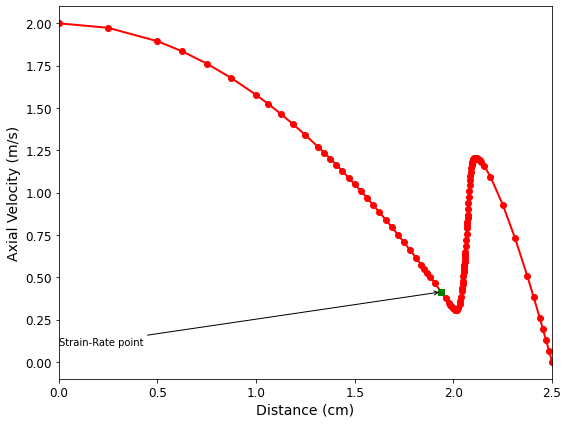

In [8]:
plt.figure()

plt.plot(opposed_flame.grid * 100, opposed_flame.velocity, "r-o", lw=2)
plt.xlim(opposed_flame.grid[0] * 100, opposed_flame.grid[-1] * 100)
plt.xlabel("Distance (cm)")
plt.ylabel("Axial Velocity (m/s)")

# Identify the point where the strain rate is calculated
plt.plot(
    opposed_flame.grid[strain_rate_point] * 100,
    opposed_flame.velocity[strain_rate_point],
    "gs",
)
plt.annotate(
    "Strain-Rate point",
    xy=(
        opposed_flame.grid[strain_rate_point] * 100,
        opposed_flame.velocity[strain_rate_point],
    ),
    xytext=(0.001, 0.1),
    arrowprops={"arrowstyle": "->"},
);

#### Temperature Plot

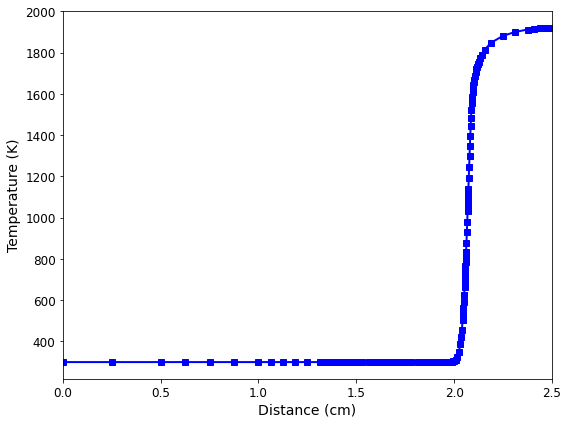

In [9]:
plt.figure()

plt.plot(opposed_flame.grid * 100, opposed_flame.T, "b-s", lw=2)
plt.xlim(opposed_flame.grid[0] * 100, opposed_flame.grid[-1] * 100)
plt.xlabel("Distance (cm)")
plt.ylabel("Temperature (K)");

#### Major Species' Plot

To plot species, we first have to identify the index of the species in the array.
For this, cut & paste the following lines and run in a new cell to get the index

```python
for i, specie in enumerate(gas.species()):
    print(f"{i}. {specie}")
```

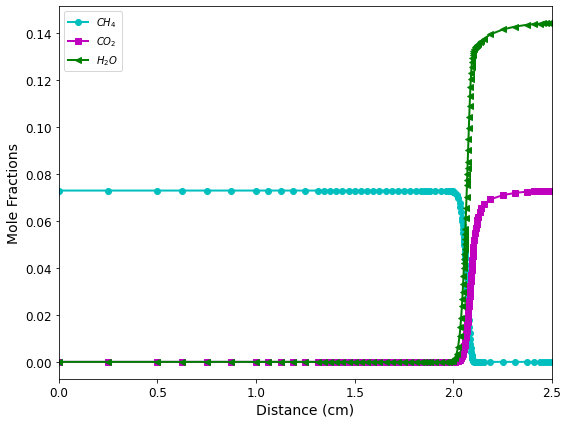

In [10]:
# Extract concentration data
X_CH4 = opposed_flame.X[13]
X_CO2 = opposed_flame.X[15]
X_H2O = opposed_flame.X[5]

plt.figure()

plt.plot(opposed_flame.grid * 100, X_CH4, "c-o", lw=2, label="$CH_{4}$")
plt.plot(opposed_flame.grid * 100, X_CO2, "m-s", lw=2, label="$CO_{2}$")
plt.plot(opposed_flame.grid * 100, X_H2O, "g-<", lw=2, label="$H_{2}O$")

plt.xlim(opposed_flame.grid[0] * 100, opposed_flame.grid[-1] * 100)
plt.xlabel("Distance (cm)")
plt.ylabel("Mole Fractions")

plt.legend(loc=2);